In [107]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
import os    # file management
import pandas as pd   # data frames
import importlib   # for reloading your own files
from termcolor import colored   # for colored error messages

# my own file:
already_imported = 'de' in globals()
try:
    import full_bubble_model as de
except:
    try:
        import Bubble_dynamics_simulation.full_bubble_model as de
    except:
        print(colored(f'Error, \'full_bubble_model.py\' not found', 'red'))
if already_imported: importlib.reload(de)   # reload changes you made

model: chemkin_AR_HE
target specie: H2
excitation: no_excitation (control parameters: [])
enable heat transfer: True	enable evaporation: True	enable reactions: True	enable dissipated energy: True


In [108]:
"""Base settings"""

directory = 'D:\\parameter_studies\\test 1'
file_base_name = 'output_'

In [199]:
"""Load all CSV files from directory into a dataframe (all_data)"""

# create a dataframe
all_data = pd.DataFrame()
num = 0
print(f'Found files:')

# iterate trough all files in directory (including subdirectories)
for (root, dirs, files) in os.walk(directory):
    for file in files:
        # ignore python rubish
        if 'ipynb_checkpoints' in root:
            continue
        # check if it's a CSV starting with file_base_name
        if file[-4:] != '.csv':
            continue
        if file[:len(file_base_name)] != file_base_name:
            continue

        # read file
        num += 1
        current_data = pd.read_csv(os.path.join(root, file))
        print(f'\t{file: <24} ({current_data.shape[0]: >4} rows)')
        all_data = pd.concat([all_data, current_data])
    
    
# Print some stats:
print(f'_______________________________________')
print(f'total number of files: {num}')
total = all_data.shape[0]
print(f'{"total:": <10} {total: < 8} rows   ( 100.00 %)')

# Print errors
def matches(error, error_code):
    errors, success = de.get_errors(error_code)
    return error in errors

for error in de.error_codes.keys():
    digit = -1; place = -1
    for i in range(10):
        if str(i) in error:
            digit = i
            place = len(error) - error.find(str(i)) - 1

    if digit < 0 and place < 0:
        print(colored(f'Error: invalid error code: {error}', 'red'))
        continue
    num = all_data.loc[(all_data['error_code'] // (10**place) % 10) == digit].shape[0]
    print(f'{error + ":": <10} {num: < 8} rows   ({(100*num/total): 7.2f} %)\t' + colored(de.error_codes[error]['describtion'], de.error_codes[error]['color']))



#for error_code in range(7):
#    num = all_data.loc[(all_data['error_code'] == error_code)].shape[0]
#    print(f'error code {error_code}: {num} rows   ({(100*num/total):.2f} %)')
#num = all_data.loc[(all_data['T_max'] > 6000.0)].shape[0]
#print(f'too hot: {num} rows    ({100*num/total:.2f} %)')
print(f'_______________________________________')

Found files:
	output_10.csv            ( 101 rows)
	output_11.csv            ( 101 rows)
	output_12.csv            (  97 rows)
	output_9.csv             ( 101 rows)
_______________________________________
total number of files: 4
total:      400     rows   ( 100.00 %)
xx0:        387     rows   (  96.75 %)	succecfully solved with LSODA solver
xx1:        13      rows   (   3.25 %)	LSODA solver didn't converge
xx2:        0       rows   (   0.00 %)	LSODA solver timed out
xx3:        0       rows   (   0.00 %)	LSODA solver had a fatal error
x0x:        400     rows   ( 100.00 %)	succecfully solved with Radau solver
x4x:        0       rows   (   0.00 %)	Radau solver didn't converge (NO SOLUTION!)
x5x:        0       rows   (   0.00 %)	Radau solver timed out (NO SOLUTION!)
x6x:        0       rows   (   0.00 %)	Radau solver had a fatal error (NO SOLUTION!)
1xx:        0       rows   (   0.00 %)	Low pressure error: The pressure of the gas is negative
2xx:        276     rows   (  69.00 %)	

In [201]:
"""Locate valid (good_data) and wrong (wrong_data) simulations"""

# Get valid datas
good_data = all_data.loc[
    (all_data['error_code'] % 100 <= 3) & ((all_data['error_code'] // 100) % 10 != 1) &
    (all_data['energy_efficiency'] > 0.0) & (all_data['energy_efficiency'] == all_data['energy_efficiency']) # positive not NaN
    # or set negative energy to inf: good_data.loc[good_data['energy'] < 0.0, 'energy'] = 1e10
]

# Everything that's not in good_data
wrong_data = pd.concat([good_data, all_data]).drop_duplicates(keep=False)

# Sort by energy
good_data = good_data.sort_values(['energy_efficiency'], ascending=True)

# New column
good_data['logE'] = np.log10(good_data['energy_efficiency'])
print(f'Good data: {good_data.shape[0]} rows ({100*good_data.shape[0]/all_data.shape[0]: .2f} %)')

Good data: 400 rows ( 100.00 %)


In [202]:
"""Let's see the dataframe"""

good_data[['ID', 'R_E', 'ratio', 'P_amb', 'alfa_M', 'T_inf', 'P_v', 'mu_L', 'gases', 'fractions', 'surfactant', 'elapsed_time', 'steps', 'collapse_time', 'T_max', f'n_{de.target_specie}', 'expansion_work', 'dissipated_acoustic_energy', 'energy_efficiency'] + de.excitation_args]

,ID,R_E,ratio,P_amb,alfa_M,T_inf,P_v,mu_L,gases,fractions,surfactant,elapsed_time,steps,collapse_time,T_max,n_H2,expansion_work,dissipated_acoustic_energy,energy_efficiency
85,286,0.000015,3.0,1000000.0,0.05,303.15,4245.125716,0.000815,9,1.0,1.0,4.043766,23208,1.391417e-06,3125.491889,2.059498e-14,3.207908e-07,0.0,7.726502e+03
39,246,0.000010,3.0,1000000.0,0.05,303.15,4245.125716,0.000815,9,1.0,1.0,2.872794,16970,9.267382e-07,3084.538111,6.043523e-15,9.522406e-08,0.0,7.815898e+03
19,326,0.000020,3.0,1000000.0,0.05,303.15,4245.125716,0.000815,9,1.0,1.0,4.131682,22546,1.856173e-06,3150.864704,4.676762e-14,7.596932e-07,0.0,8.057779e+03
6,10,0.000001,5.0,1000000.0,0.05,303.15,4245.125716,0.000815,9,1.0,1.0,1.026746,6703,1.470997e-07,3903.318187,3.095820e-17,5.158606e-10,0.0,8.265688e+03
44,50,0.000002,5.0,1000000.0,0.05,303.15,4245.125716,0.000815,9,1.0,1.0,1.504628,9264,2.956764e-07,4107.982814,2.399500e-16,4.051707e-09,0.0,8.376056e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,202,0.000007,2.0,1000000.0,0.05,303.15,4245.125716,0.000815,9,1.0,1.0,3.549172,20748,5.033231e-07,1368.218436,-2.853741e-22,8.740525e-09,0.0,1.000000e+30
23,124,0.000004,2.0,5000000.0,0.05,303.15,4245.125716,0.000815,9,1.0,1.0,2.229899,12239,1.213428e-07,1417.863740,-2.511407e-22,6.613331e-09,0.0,1.000000e+30
24,123,0.000004,2.0,2500000.0,0.05,303.15,4245.125716,0.000815,9,1.0,1.0,2.340423,13947,1.705519e-07,1407.296077,-1.110976e-23,3.315541e-09,0.0,1.000000e+30
4,2,0.000001,2.0,1000000.0,0.05,303.15,4245.125716,0.000815,9,1.0,1.0,0.605142,4224,6.624213e-08,1090.590612,-4.177916e-26,2.198313e-11,0.0,1.000000e+30


In [203]:
"""Print some statistics"""

good_data[['ID', 'R_E', 'ratio', 'P_amb', 'alfa_M', 'T_inf', 'P_v', 'mu_L', 'gases', 'fractions', 'surfactant', 'elapsed_time', 'steps', 'collapse_time', 'T_max', f'n_{de.target_specie}', 'expansion_work', 'dissipated_acoustic_energy', 'energy_efficiency'] + de.excitation_args].describe()

,ID,R_E,ratio,P_amb,alfa_M,T_inf,P_v,mu_L,gases,fractions,surfactant,elapsed_time,steps,collapse_time,T_max,n_H2,expansion_work,dissipated_acoustic_energy,energy_efficiency
count,400.000000,400.000000,400.000000,4.000000e+02,400.00,4.000000e+02,400.000000,400.000000,400.0,400.0,400.0,400.000000,400.000000,4.000000e+02,400.000000,4.000000e+02,4.000000e+02,400.0,4.000000e+02
mean,200.500000,0.000009,20.000000,2.150000e+06,0.05,3.031500e+02,4245.125716,0.000815,9.0,1.0,1.0,3.356421,16780.565000,7.254290e-06,3221.906840,1.171402e-12,6.285266e-04,0.0,3.750001e+28
std,115.614301,0.000008,15.472508,1.857721e+06,0.00,1.138292e-13,0.000000,0.000000,0.0,0.0,0.0,2.847475,9914.463953,1.382910e-05,1080.502850,4.498872e-12,3.005238e-03,0.0,1.902215e+29
min,1.000000,0.000001,2.000000,1.000000e+05,0.05,3.031500e+02,4245.125716,0.000815,9.0,1.0,1.0,0.330099,2395.000000,3.042894e-08,563.953249,-2.853741e-22,3.433060e-12,0.0,7.726502e+03
25%,100.750000,0.000003,5.000000,7.750000e+05,0.05,3.031500e+02,4245.125716,0.000815,9.0,1.0,1.0,1.956912,11603.500000,7.549725e-07,2346.205410,8.786632e-17,8.374185e-08,0.0,8.651858e+04
50%,200.500000,0.000006,17.500000,1.750000e+06,0.05,3.031500e+02,4245.125716,0.000815,9.0,1.0,1.0,2.713836,15084.000000,2.330491e-06,3306.719114,9.174918e-15,2.546453e-06,0.0,1.666242e+05
75%,300.250000,0.000015,30.000000,3.125000e+06,0.05,3.031500e+02,4245.125716,0.000815,9.0,1.0,1.0,3.864692,20731.500000,7.309412e-06,3924.214853,1.792669e-13,6.919389e-05,0.0,3.236048e+06
max,400.000000,0.000025,50.000000,5.000000e+06,0.05,3.031500e+02,4245.125716,0.000815,9.0,1.0,1.0,22.507304,132338.000000,1.180366e-04,5619.180033,4.975030e-11,4.086867e-02,0.0,1.000000e+30


succecfully solved with LSODA solver


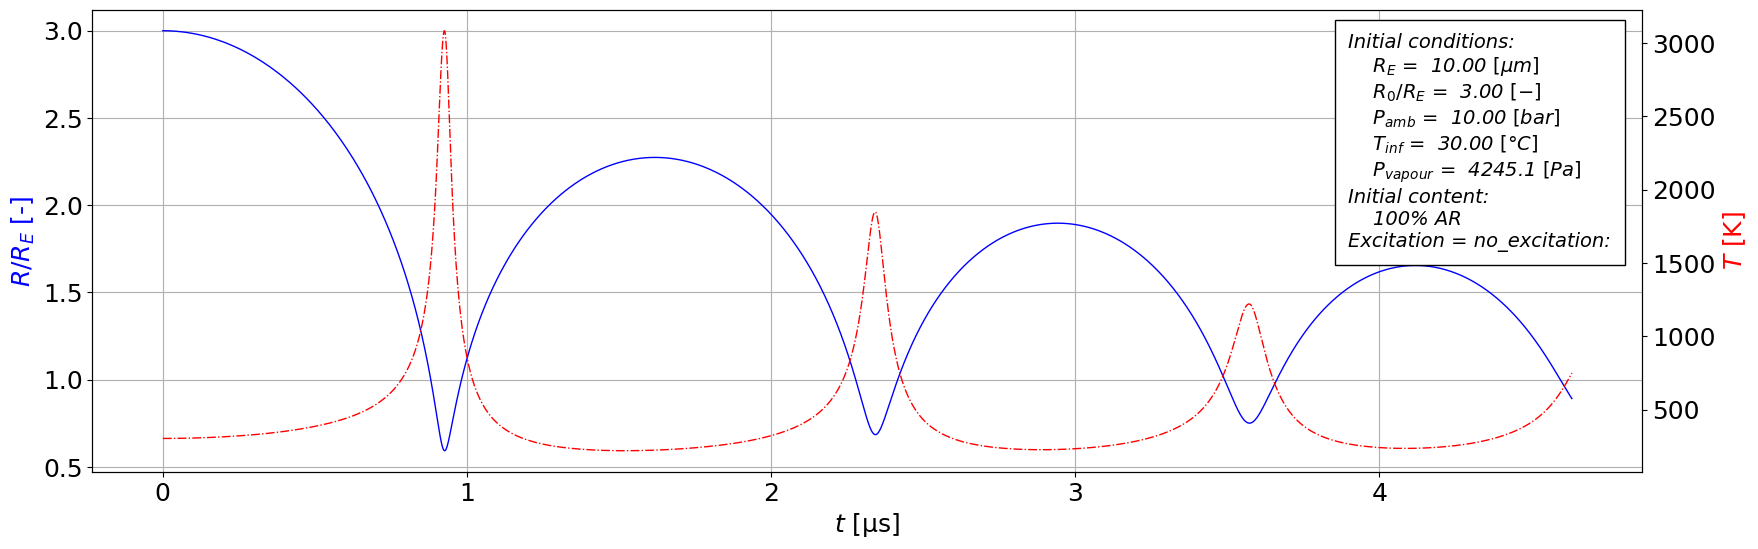

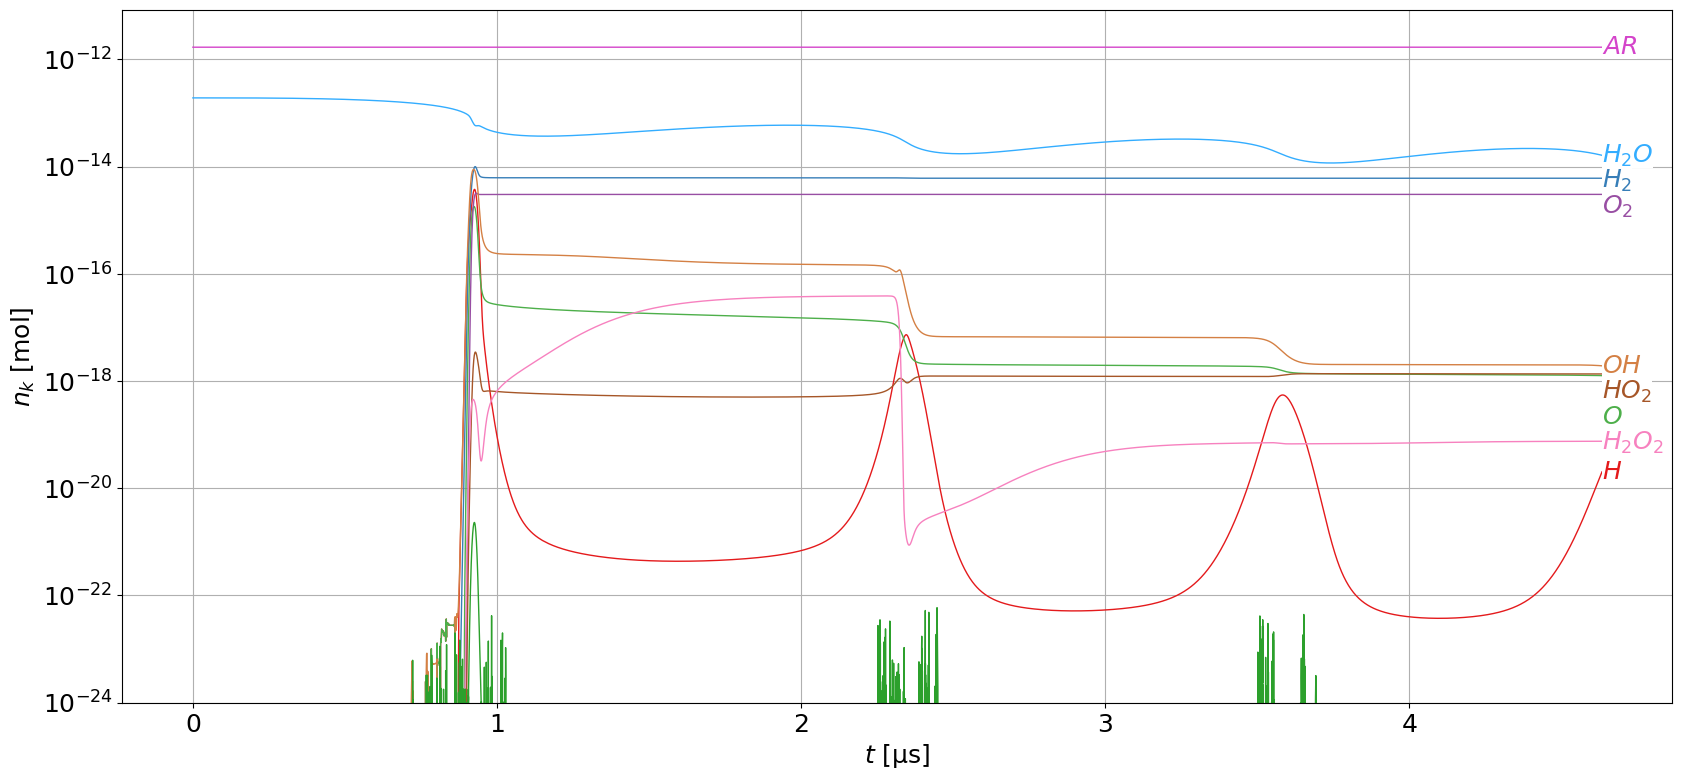

Control parameters:
    ID = 246
    R_E = 10.00 [um]
    ratio = 3.00 [-]
    P_amb = 10.00 [bar]
    alfa_M = 0.05 [-]
    T_inf = 30.00 [°C]
    P_v = 4245.13 [Pa]
    mu_L = 0.81 [mPa*s]
    surfactant = 1.00 [-]    
    excitation = 'no_excitation'
   )
    Initial content: 100% AR
Simulation info:
    error_code = 0
    elapsed_time = 1.40 [s]
    steps = 18215 [-]
Final state:
    R_final = 10.02 [um];   R_dot_final =-2.977241667605209e-17 [m/s];   T_final = 303.15 [K]
    n_H2_final = 6.04e-15 [mol]
    Final molar concentrations: [mol/cm^3]
        H     :   -4.067179975820996e-25;    H2    :   1.4349982682669737e-06;    O     :  -2.1851502508235082e-19;    O2    :    7.174353710258363e-07;    
        OH    :  -3.4431014144167984e-23;    H2O   :   1.6842204457209335e-06;    N2    :    4.617302950891615e-26;    HO2   :  -4.6060888362966884e-12;    
        H2O2  :    1.344353487758541e-10;    AR    :    0.0003986058146762859;    HE    :                      0.0;    OHEX  :   5

In [204]:
"""Plot a certain simulation"""

# converts a line of all_data to a dictionary containing the control parameters (cpar)
def line_to_dict(line):
    gases = str(line['gases'])
    fractions = str(line['fractions'])
    return de.dotdict(dict(
        ID=line['ID'],
        R_E=line['R_E'], # [m]
        ratio=line['ratio'], # [-]
        P_amb=line['P_amb'], # [Pa]
        alfa_M=line['alfa_M'], # [-]
        T_inf=line['T_inf'], # [m]
        surfactant=line['surfactant'], # [-]
        P_v=line['P_v'], # [Pa]
        mu_L=line['mu_L'], # [Pa*s]
        gases=[int(index) for index in gases.split(' ') if index!=''],  # indexes of species in initial bubble
        fractions=[float(frac) for frac in fractions.split(' ') if frac!=''], # molar fractions of species in initial bubble
    ))
cpar = line_to_dict(good_data.iloc[1])   # choose the most energy efficient one
de.plot(cpar)